In [1]:
import pandas as pd
import os
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# you're going to want to go to your own directory
# and have your own copy of the data

os.chdir('C:\\Users\mattc\Downloads')
df = pd.read_csv('CyclistCrashes.csv')

In [3]:
# OK, so we're taking that dataframe, and putting it into a Geo DataFrame
# creating shapely points, setting the projection (crs) etc.

# projections are hard.   This one is one Sally found.

geometry = [Point(xy) for xy in zip(df.LONGITUDE, df.LATITUDE)]
df = df.drop(['LONGITUDE', 'LATITUDE'], axis=1)
crs = {'init': 'epsg:32755'}
geo_df = GeoDataFrame(df, crs=crs, geometry=geometry)
geo_df.head()

,CRASH_ID,CRASH_DATE,CRASH_TIME,SEVERITY,CRASH_TYPE,CYCLISTS,CYCLIST_CASUALTIES,REPORTED_LOCATION,LOCATION_1,geometry
0,1034637,14 May 2012,12:37,Injury,Collision with parked vehicle,1,1,CAPITAL CIRCLE (COMMONWEALTH/COMMSPARLERM -> C...,"(-35.304932, 149.125419)",POINT (149.125419 -35.304932)
1,1055714,20 February 2013,07:57,Injury,Right turn into oncoming vehicle,1,1,MORPHETT/NORTHBOURNE INTERSECTION,"(-35.253575, 149.133358)",POINT (149.133358 -35.253575)
2,1083381,17 March 2014,07:30,Injury,Same direction side swipe,1,1,BUNDA/NORTHBOURNE/RUDD INTERSECTION,"(-35.277135, 149.129453)",POINT (149.129453 -35.27713499999999)
3,1025046,04 January 2012,08:50,Property Damage Only,Other - Vehicle to Vehicle,1,0,BARRY/COOYONG/NORTHBOURNE INTERSECTION,"(-35.275784, 149.129771)",POINT (149.129771 -35.275784)
4,1107433,07 April 2015,08:05,Property Damage Only,Other - Vehicle to Vehicle,1,0,NORTHBOURNE AVENUE (MORPHETT -> MURDOCH),"(-35.252917, 149.133364)",POINT (149.133364 -35.252917)


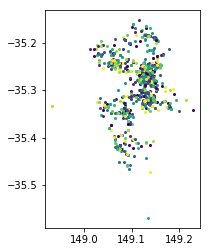

In [4]:
# lets look at that!  Should look a bit like Canberra
geo_df.plot()

In [5]:
# Now I want a reference list of "dangerzones" - more than 2 registered crashes (arbitrary number)

tally = pd.DataFrame(df.groupby('REPORTED_LOCATION').count().loc[:,'CYCLISTS'])
dangerzones = pd.DataFrame(tally[tally['CYCLISTS'] > 2].index)
dangerzones.head()

,REPORTED_LOCATION
0,AINSLIE/LIMESTONE INTERSECTION
1,ALEXANDRINA/CORONATION/FLYNN INTERSECTION
2,ANTILL/MOUAT/NORTHBOURNE INTERSECTION
3,ATHLLON/BEASLEY (SW) INTERSECTION
4,ATHLLON/DRAKEFORD/ISABELLA INTERSECTION


In [6]:
# use the dangerzone list filter the original geo_df to only include those locations
# (i.e) if there's only one or two, they're being ditched.

test = geo_df['REPORTED_LOCATION'].isin(dangerzones['REPORTED_LOCATION'])
dangerzone_hits = geo_df[test]

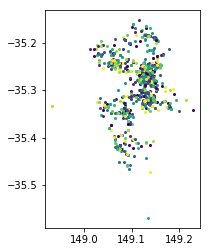

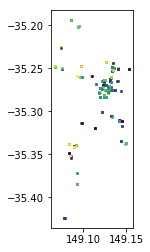

In [7]:
# compare the full plot to the dangerzone plot - should be sparser
geo_df.plot()
dangerzone_hits.plot()



In [8]:
# THIS IS THE BIT AT WHICH YOU SHOULD SEND SALLY THE DATA ('dangerzone_hits')
# EVERYTHING ELSE WAS EXPERIMENTATION THAT DIDN'T QUITE WORK
# WELL IT DID WORK, BUT IT DIDN'T EXPORT GREAT
# SALLY CAN DO IT AND MORE IN ARC
# YAY SALLY

# We learnt a lot though.
# Like: don't learn Geo at GovHack

In [9]:
# store the dangerzone geometry only (reducing number of columns)

#dangerzone_hits_geo = dangerzone_hits[['REPORTED_LOCATION','geometry']].sort_values('REPORTED_LOCATION')
#dangerzone_hits_geo.head()

In [10]:
# put all the points into a single row for each location
# this will probably screw up the projections (crs).  Don't learn Geo at GovHack.

dissolved = GeoDataFrame(dangerzone_hits.dissolve('REPORTED_LOCATION'), crs=crs)


In [12]:
# this will provided the minimal N-S, E-W rectangle that contains all the points in each row of dissolved
# this has been superceded by work with buffers and in arc, but it took ages so I'm leaving it here

# Row 4 or something has just a single point which stuffs it up (the buffer should fix that)
# ENVELOPED

enveloped = dissolved.envelope
enveloped.columns = ['geometry']
print(enveloped.head(10))

REPORTED_LOCATION
AINSLIE/LIMESTONE INTERSECTION               POLYGON ((149.143722 -35.276403, 149.143848 -3...
ALEXANDRINA/CORONATION/FLYNN INTERSECTION    POLYGON ((149.121906 -35.300644, 149.122262 -3...
ANTILL/MOUAT/NORTHBOURNE INTERSECTION        POLYGON ((149.134102 -35.248345, 149.134301 -3...
ATHLLON/BEASLEY (SW) INTERSECTION                                POINT (149.092895 -35.371915)
ATHLLON/DRAKEFORD/ISABELLA INTERSECTION      POLYGON ((149.07791 -35.424077, 149.078527 -35...
ATHLLON/SULWOOD INTERSECTION                 POLYGON ((149.092808 -35.384625, 149.093074 -3...
BARRY/BOLDREWOOD INTERSECTION                POLYGON ((149.120268 -35.27301, 149.120306 -35...
BARRY/COOYONG/NORTHBOURNE INTERSECTION       POLYGON ((149.129487 -35.275854, 149.129887 -3...
BARRY/MARCUS CLARKE INTERSECTION             POLYGON ((149.126717 -35.275627, 149.1268 -35....
BARRY/MCCAUGHEY/NORTH INTERSECTION           POLYGON ((149.121763 -35.273574, 149.121966 -3...
dtype: object


                                                                                    geometry
REPORTED_LOCATION                                                                           
AINSLIE/LIMESTONE INTERSECTION             POLYGON ((149.1436942925883 -35.27627102494088...
ALEXANDRINA/CORONATION/FLYNN INTERSECTION  (POLYGON ((149.122362 -35.300487, 149.12236151...
ANTILL/MOUAT/NORTHBOURNE INTERSECTION      POLYGON ((149.1340183624033 -35.24829026155257...
ATHLLON/BEASLEY (SW) INTERSECTION          POLYGON ((149.092995 -35.371915, 149.092994518...
ATHLLON/DRAKEFORD/ISABELLA INTERSECTION    (POLYGON ((149.0784473044783 -35.4241372107507...


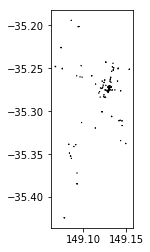

In [13]:
# so this is attempting to draw polygons around the points
# but I have no idea what units the buffer command is using
# and we might have lost the crs  don't know.

# Sally should just do all this in arc

# BUFFERED

buffered = GeoDataFrame(dissolved.buffer(0.0001), crs={'init': 'epsg:32755'})
buffered.columns = ['geometry']
print(buffered.head())
buffered.plot()

In [ ]:
# this will send the buffered results to a file
# except it doesn't work
# Sally should do this all in arc
buffered.to_file('buffered')